# Test flight data from 29 October 2021, NWC/NSSL, Norman, OK

**First processed: 3 Nov 2021, Eric Bruning, TTU**
Revised processing 10-14 June 2022, ECB, TTU.

The processing here is quite preliminary, but shows that we can demodulate the data using the same signal processing as the previous instrument (after porting it to Python). The theory needs to be reexamined to take advantage of the z component acceleration.

The retrieved orientation has not been checked with the calibration stand data.

The calculation of the quadrature axial rotation signal uses a different sign from the previous processing, as noted below.

To retrieve the reference spin and rotation signals, both in phase and quadrature, the accelerometer and magnetometer data are fit with an idealized cosine every 4 s in overlapping chunks. The frequency and phase of the fit cosine data are used to construct unit-amplitude reference signals. The signal processing is done with these reference signals. The reconstruction is not perfect. A fun byproduct is that the fitting generates a time series of the varying spin amplitude, phase, and frequency.

The demodulation of the horizontal components is not perfect, showing substantial influence of the rotation frequency, but they are tiny tiny signals, and may not be reliable at all.

## Running the analysis

Run the cells in order.

Just below the print out of the data tables, there is a cell of various index ranges that can be used to plot various parts of the raw flight data.

## Things to notice in the analyses below

- GPS data never seem to budge from the initial location.
- Temperature never decreases below 0°C.
- The instrument seems to be spinning from the first moment of data collction. That's surprising.
- Spin seems to slow down about 20 min in, and then stop at about 30 min. Doesn't seem to recover. Motor ran out of battery?
- The z gyro is off scale, until it gets really cold and/or the battery voltage drops.
- There was about 2 kV/m at the surface, and it decayed exponentially with height. Is this physical under the observed clear skies and very windy conditions?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from scipy.signal import medfilt, find_peaks
%matplotlib inline

import efmlib

In [2]:
plt.rcParams['figure.figsize'] =  10, 7.5
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['text.color'] = 'black'
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5

In [3]:
filenames = glob.glob('./20211029/SDCardRawData/EFM*.TXT')
filenames.sort()
df_fiber, df_gps = efmlib.read_efm_raw(filenames, shift_dt=0.0)

Shifting ADC backward by 0.0 original samples.


In [4]:
for k, v in efmlib.valid_ranges.items():
    mean = (v[1]+v[0])/2.0
    vals = df_fiber[k].values
    bad = (vals < v[0]) | (vals > v[1])
    nbad = bad.sum()
    print(f'Setting {nbad} bad values in {k} to {mean}')
    df_fiber[k].mask(bad, other=mean, inplace=True)
    

Setting 213 bad values in adc_volts to 0.0
Setting 50 bad values in acceleration_x to 0.0
Setting 56 bad values in acceleration_y to 0.0
Setting 32 bad values in acceleration_z to 0.0
Setting 32 bad values in magnetometer_x to 50.0
Setting 46 bad values in magnetometer_y to 0.0
Setting 142 bad values in magnetometer_z to 0.0
Setting 86 bad values in gyroscope_x to 0.0
Setting 96 bad values in gyroscope_y to 0.0
Setting 32618 bad values in gyroscope_z to 0.0


/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [5]:
df_fiber.head(10)

,start_byte,adc_ready_millis,adc_reading,acceleration_x,acceleration_y,acceleration_z,magnetometer_x,magnetometer_y,magnetometer_z,gyroscope_x,gyroscope_y,gyroscope_z,temperature,relative_humidity,pressure,end_byte,adc_volts_withlag,adc_volts
0,190,226421,110201,-2.592623,4.393222,-4.791627,79.465065,-3.580824,-19.438761,4.414570,0.363618,0.0,25.3,16,941.9,239,0.053809,0.053809
1,190,226471,138900,-4.841279,0.593420,-5.526224,71.996490,23.516516,-18.605671,3.763846,-2.128102,0.0,25.3,16,941.9,239,0.067822,0.067822
2,190,226621,95871,-16.291534,0.415753,3.525226,-3.098509,7.337036,-7.775504,-3.497509,-2.523484,0.0,25.3,16,938.5,239,0.046812,0.046812
3,190,226671,55949,-15.818950,5.571687,5.239085,3.449284,-24.364222,-2.104648,-4.427246,0.173638,0.0,25.3,16,938.5,239,0.027319,0.027319
4,190,226721,30736,-15.026328,10.357333,6.716055,29.991230,-44.694534,6.255481,-3.581656,2.886491,0.0,25.3,16,938.5,239,0.015008,0.015008
5,190,226771,29298,-11.295918,15.570696,3.707081,58.374744,-45.761471,12.598655,-1.168432,4.567897,0.0,25.3,16,938.5,239,0.014306,0.014306
6,190,226821,50266,-3.868596,13.899906,-2.617150,83.878983,-27.389652,19.921076,1.820531,4.268574,0.0,25.3,16,938.5,239,0.024544,0.024544
7,190,226871,85648,0.357129,8.105089,-7.663613,91.347557,-4.121602,26.629642,3.844328,2.118633,0.0,25.3,16,938.5,239,0.041820,0.041820
8,190,226921,121103,1.187438,2.182853,-8.312666,84.317451,21.441099,30.371237,4.201989,-0.628886,0.0,25.3,16,938.5,239,0.059132,0.059132
9,190,226971,142394,-2.638685,-1.431506,-8.371888,66.354866,39.111370,32.885124,2.889393,-2.983618,0.0,25.3,16,938.5,239,0.069528,0.069528


In [6]:
df_fiber.tail(10)

,start_byte,adc_ready_millis,adc_reading,acceleration_x,acceleration_y,acceleration_z,magnetometer_x,magnetometer_y,magnetometer_z,gyroscope_x,gyroscope_y,gyroscope_z,temperature,relative_humidity,pressure,end_byte,adc_volts_withlag,adc_volts
242820,190,12377224,152988,-6.418149,-3.267998,-6.994221,28.237358,33.703594,47.106110,-0.018937,0.037110,0.014508,32.5,12,988.9,239,0.074701,0.074701
242821,190,12377274,153159,-6.422935,-3.281756,-6.942177,28.412745,34.098217,46.769951,-0.018784,0.076205,0.020006,32.5,12,988.9,239,0.074785,0.074785
242822,190,12377324,152985,-6.416952,-3.282953,-6.922436,28.515053,33.791290,47.003799,-0.022297,0.033750,0.018021,32.5,12,988.9,239,0.074700,0.074700
242823,190,12377374,153067,-6.387042,-3.291328,-6.930811,28.441978,34.302837,47.135342,-0.018937,0.040317,0.019700,32.5,12,988.9,239,0.074740,0.074740
242824,190,12377424,153086,-6.435497,-3.288935,-6.891928,28.266588,34.142067,47.252266,-0.018479,0.040623,0.022449,32.5,12,988.9,239,0.074749,0.074749
242825,190,12377474,153022,-6.416354,-3.290131,-6.990033,28.412745,34.244373,47.778427,-0.019242,0.034208,0.024129,32.5,12,988.9,239,0.074718,0.074718
242826,190,12377524,153015,-6.424130,-3.299703,-6.961319,28.368898,34.595146,46.872257,-0.020006,0.038026,0.020922,32.5,12,988.9,239,0.074714,0.074714
242827,190,12377574,153029,-6.442675,-3.299703,-6.970293,28.368898,34.244373,48.012276,-0.021228,0.036346,0.019548,32.5,12,988.9,239,0.074721,0.074721
242828,190,12377624,153213,-6.406185,-3.303292,-6.940382,28.178894,34.463608,47.705349,-0.018326,0.036652,0.017715,32.5,12,988.9,239,0.074811,0.074811
242829,190,12377674,153117,-6.399006,-3.326023,-6.952346,28.061972,34.039753,47.895351,-0.022907,0.075595,0.018326,32.5,12,988.9,239,0.074764,0.074764


In [7]:
df_gps.head()

,start_byte,millis,latitude,longitude,altitude,gps_time,end_byte
0,254,615383040,185806.0654,124389.0017,16588,NaT,237
1,254,2686203838,-160835.3472,28525.6640,6912,NaT,237
2,254,1380008009,141772.3795,-185049.0609,17089,NaT,237
3,254,2933670026,174137.3625,-95533.4759,16524,NaT,237
4,254,3622257096,167734.4920,57837.1583,49312,NaT,237


In [8]:
first_secs_t0 = 0
first_secs = (first_secs_t0, first_secs_t0+12*60)
updown_estimate_idxrange = (0, 115000)
up_estimate_idxrange = (0, 66500)
down_estimate_idxrange = (66500, 115000)
top_estimate_idxrange = (62000, 72000)

good_accel = (0, 20000)
spin_dies = (30000, 45000) # ran out of battery perhaps? Doesn't seem to come back.
descent_tenC = (110000, 111000)

# estimate_idxrange = updown_estimate_idxrange 
estimate_idxrange = good_accel
# estimate_idxrange = first_secs

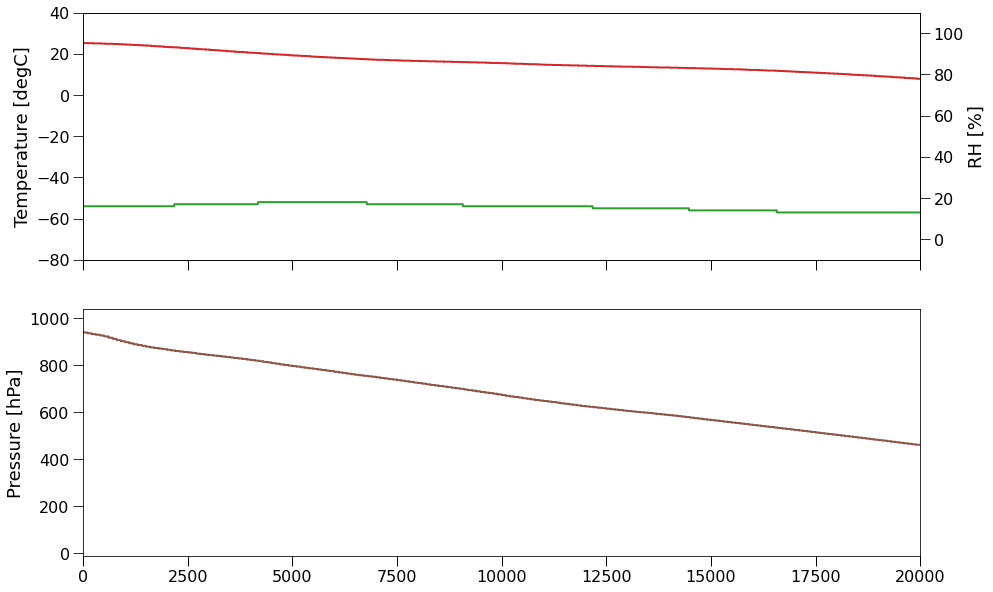

In [9]:
fig, [ax1, ax2] = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)
ax1b = ax1.twinx()
ax1.plot(medfilt(df_fiber['temperature'],3), color='tab:red')
ax1b.plot(medfilt(df_fiber['relative_humidity'],3), color='tab:green')
ax2.plot(medfilt(df_fiber['pressure'], 3), color='tab:brown')
ax1.set_ylabel('Temperature [degC]')
ax1b.set_ylabel('RH [%]')
ax2.set_ylabel('Pressure [hPa]')
ax1.set_xlim(*estimate_idxrange)
ax1.set_ylim(-80, 40)
ax1b.set_ylim(-10, 110)
# ax2.set_ylim(0,100)
fig.savefig('PTH.pdf')

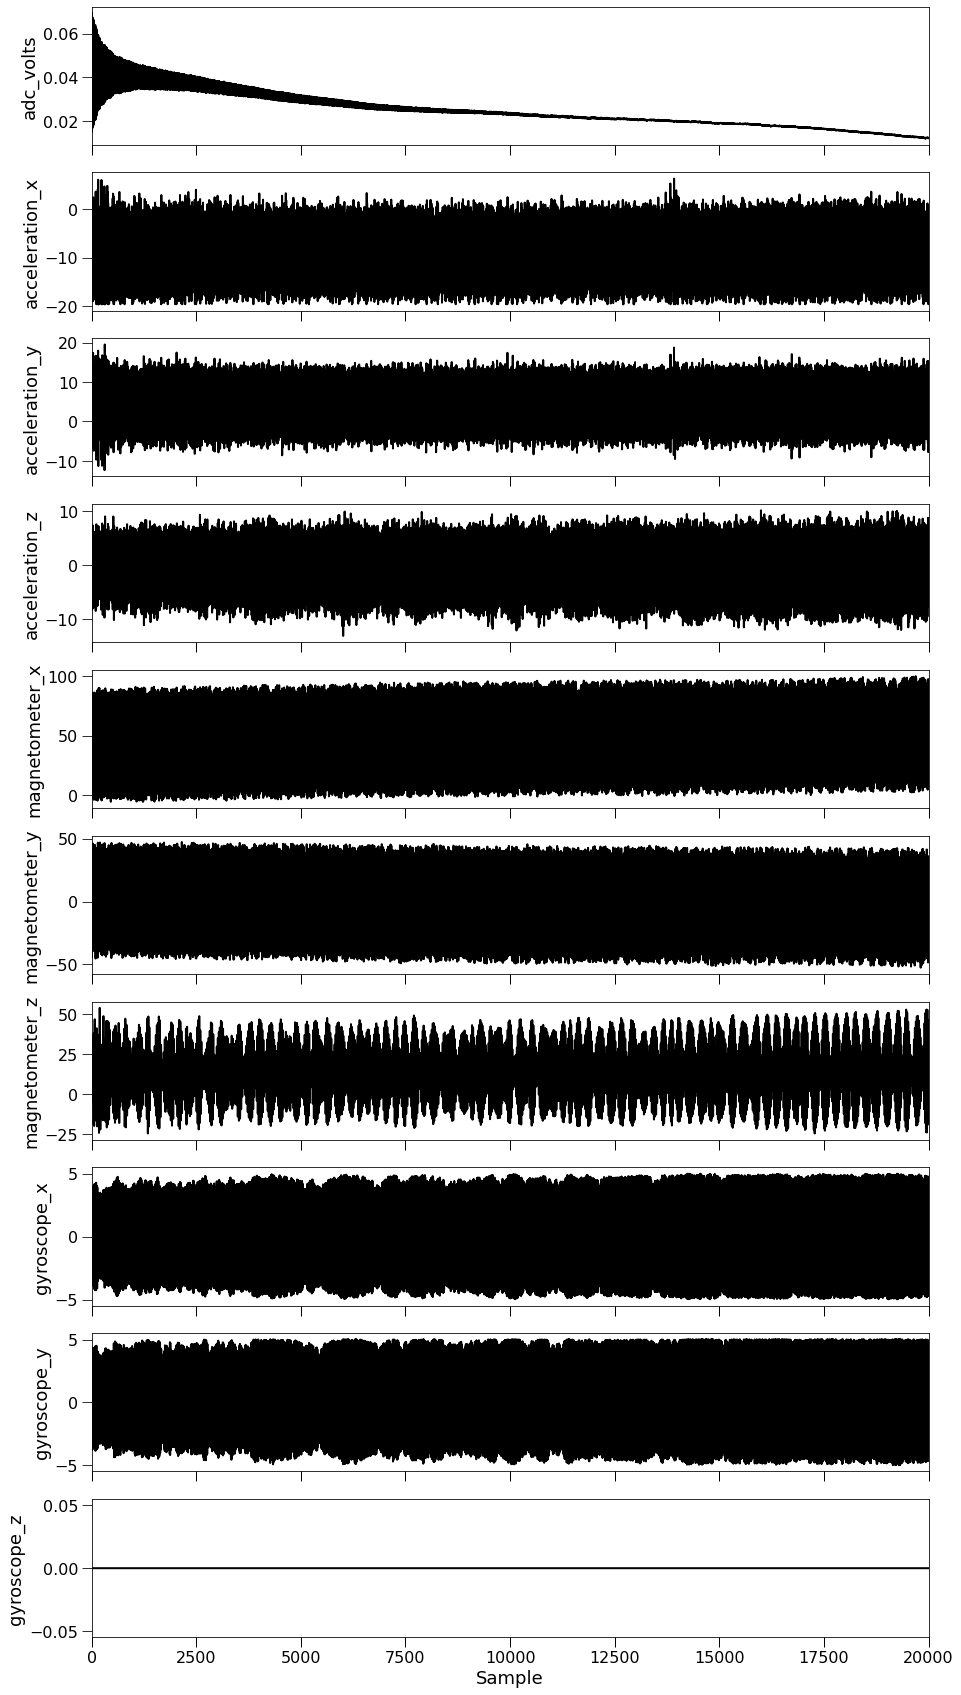

In [10]:
fields = ['adc_volts', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z']
# fields = ['acceleration_x', 'acceleration_y', 'adc_volts', 'adc_volts_withlag', ]

fig, axes = plt.subplots(figsize=(15, 30), nrows=len(fields), sharex=True)
for fname, ax in zip(fields, axes):
    ax.plot(medfilt(df_fiber[fname][slice(*estimate_idxrange)],3), color='k')
    ax.set_ylabel(fname)
axes[-1].set_xlabel('Sample')
ax.set_xlim(*estimate_idxrange)
fig.savefig('raw_trace.pdf')

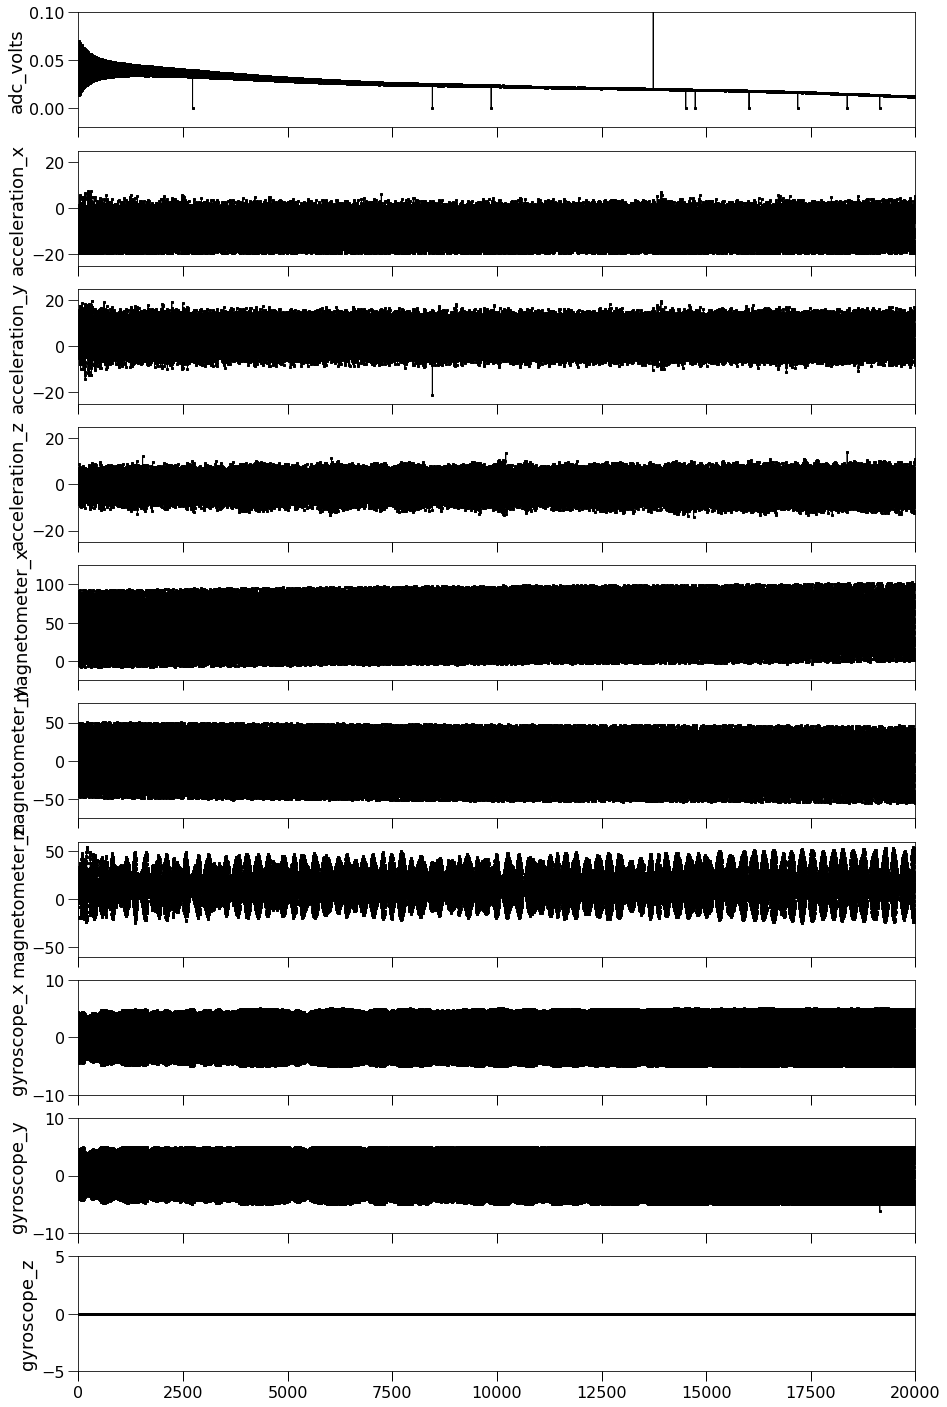

In [11]:
fields = ['adc_volts', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z', ]
ranges = [ (-.02, .1), 
          (-25, 25), (-25, 25), (-25, 25), (-25,125), (-75, 75), (-60, 60), (-10, 10), (-10, 10), (-5, 5),]
fig, axes = plt.subplots(figsize=(15, 25), nrows=len(fields), sharex=True)
for fname, ax, ylims in zip(fields, axes, ranges):
#     ax.plot(medfilt(df_fiber[fname],3), color='k')
    # ax.plot(medfilt(df_fiber[fname],3), color='k', marker='s', linewidth=1, markersize=2)
    ax.plot(df_fiber[fname], color='k', marker='s', linewidth=1, markersize=2)
    ax.set_ylabel(fname)
    ax.set_ylim(ylims)
ax.set_xlim(*estimate_idxrange)
fig.savefig('raw_sensor_data.pdf')

#### fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_fiber['adc_volts'], color='k')
ax.set_ylabel('ADC [Volts]')
ax.set_xlim(*estimate_idxrange)
ax.set_ylim(-.02, .1)

In [12]:
med_filt_adc = medfilt(df_fiber['adc_volts'],3)

(-0.02, 0.1)

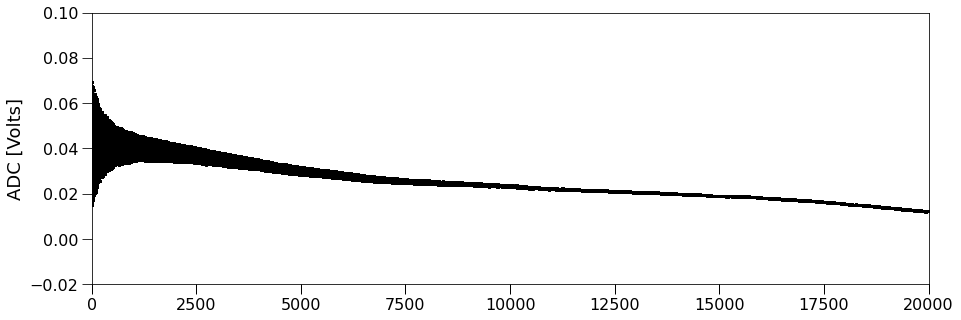

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(med_filt_adc, color='k', marker='s', linewidth=1, markersize=2)
ax.set_ylabel('ADC [Volts]')
ax.set_xlim(*estimate_idxrange)
ax.set_ylim(-.02, 0.1)

In [14]:
peak_idx, peak_data = find_peaks(med_filt_adc, distance=9)
neg_peak_idx, neg_peak_data = find_peaks(-med_filt_adc, distance=9)

(-0.02, 0.1)

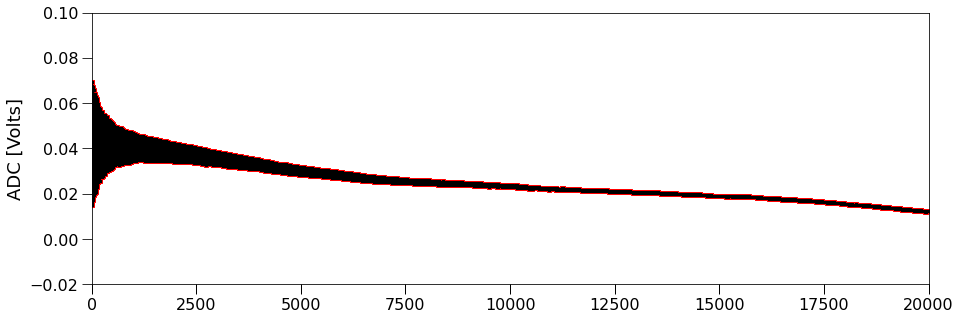

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(peak_idx, med_filt_adc[peak_idx], 
        color='r', marker='s', linewidth=None, markersize=4)
ax.plot(neg_peak_idx, med_filt_adc[neg_peak_idx], 
        color='r', marker='s', linewidth=None, markersize=4)

ax.plot(med_filt_adc, color='k', marker='s', linewidth=1, markersize=2)

ax.set_ylabel('ADC [Volts]')
ax.set_xlim(*estimate_idxrange)
ax.set_ylim(-.02, 0.1)

0.057482910156251864


(-0.01, 0.06)

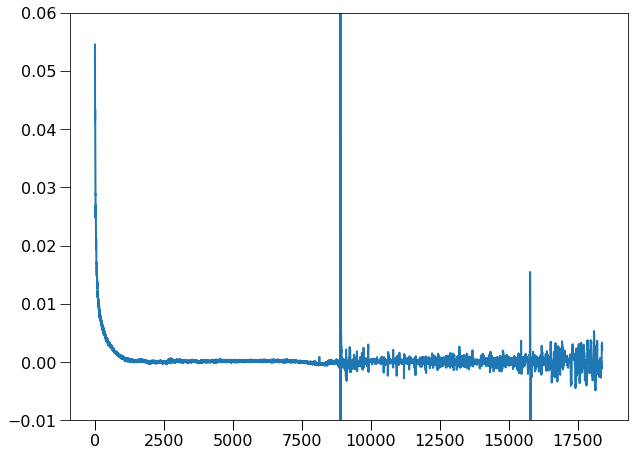

In [16]:
# This is not ideal, but max of maxes minus min of mins is an ok estimate of the peak to peak voltage.
n_peaks = min(peak_idx.shape[0], neg_peak_idx.shape[0])
max_idx_critter = (peak_idx >= estimate_idxrange[0]) & (peak_idx < estimate_idxrange[1])
min_idx_critter = (neg_peak_idx >= estimate_idxrange[0]) & (neg_peak_idx < estimate_idxrange[1])
peak_peak_range = (med_filt_adc[peak_idx[max_idx_critter]]).max() - (med_filt_adc[neg_peak_idx[min_idx_critter]]).min()
print(peak_peak_range)

# This is a bad way to match up the peaks, since it assumes that there is an alternating set of positive
# and negative peaks, instead of matching them by index.
peak_peak_range = med_filt_adc[peak_idx[:n_peaks]] - med_filt_adc[neg_peak_idx[:n_peaks]]
plt.plot(peak_peak_range)
plt.gca().set_ylim(-.01, .06)

In the Bruning (2003) EFM calibration document for the old EFM, the recommended calibraiton equation was

\begin{equation}
8.8 \times 10^{11} (\sqrt{1 + (\omega R C)^{-2}}) C  E_\mathrm{dig} \frac{V_\mathrm{range}}{q_n}
\end{equation}

where $E_\mathrm{dig}$ is the sinusoidal amplitude (not peak-to-peak) in digital units before converstion to a voltage. In other words $E_\mathrm{dig} \frac{V_\mathrm{range}}{q_n} = \frac{V_\mathrm{pp}}{2}$: half the peak-to-peak voltage.

In this dataset, the voltage is already converted for us, above, and acocunts for the new 24 bit ADC and the presence of an additional voltage divider, so I think the new calibration equation should be

\begin{equation}
8.8 \times 10^{11} (\sqrt{1 + (\omega R C)^{-2}}) C  \frac{V_\mathrm{pp}}{2}
\end{equation}



V_range = 4.096 * 2
q_n = 2^24

 ```
 adc_cal = (2 * 2.048) / 2**24
 adc_cal *= 2 # For voltage divider that is in-place
 df_fiber['adc_volts'] = adc_cal * df_fiber['adc_reading']
 ```

In [17]:
f_spin = 2 # Hz
omega = 2*np.pi*f_spin # Angular frequency of spheres' spin
resistance = 1e8 # ohms
capacitance = 1e-7 #Farads
omega_RC = omega*resistance*capacitance
# This number should be large (order 10^2) so that E_h and E_v remain separable.
print("omega RC = ", omega_RC)

omega RC =  125.66370614359171


In [18]:
def calibrated_E(peak_to_peak_range):
    E_mag = (8.8e11 * np.sqrt((1 + 1.0/(omega_RC*omega_RC))) * 
             capacitance * peak_to_peak_range/2.0
            )
    return E_mag

(0.0, 1500.0)

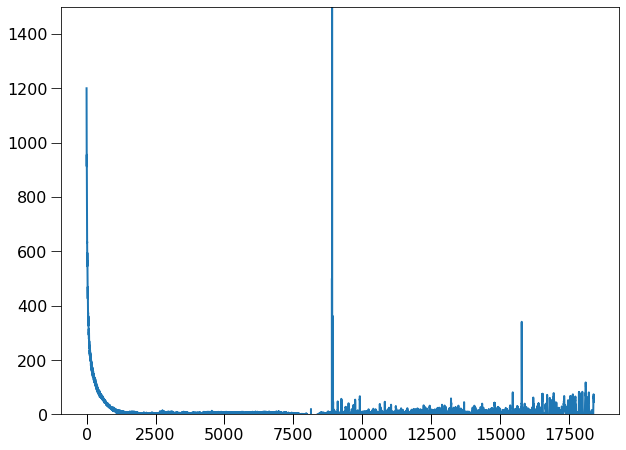

In [19]:
plt.plot(calibrated_E(peak_peak_range)/2)
plt.ylim(0, 1500)

In [20]:
good_latlonalt = ((df_gps['latitude'] < 40) & (df_gps['latitude'] > 30))
good_latlonalt &= ((df_gps['longitude'] < -90) & (df_gps['longitude'] > -110))
good_latlonalt &= ((df_gps['altitude'] < 40e3) & (df_gps['altitude'] > 0))
filt_gps = df_gps[good_latlonalt]
med_lon, med_lat = np.median(filt_gps['longitude']), np.median(filt_gps['latitude'])
print(med_lon, med_lat)

-97.0721 34.0245


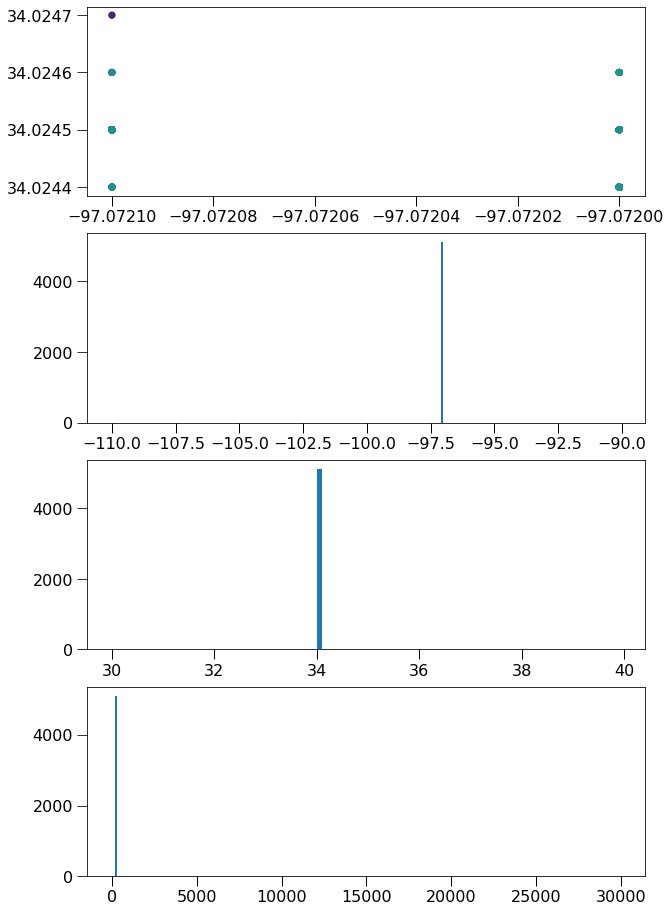

In [21]:
fig, [ax, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(10,16))
ax.scatter(filt_gps['longitude'], filt_gps['latitude'], c=filt_gps['altitude'])
ax2.hist(filt_gps['longitude'], bins=np.arange(-110,-90,.1))
ax3.hist(filt_gps['latitude'], bins=np.arange(30,40,.1))
ax4.hist(filt_gps['altitude'], bins=np.arange(0,30000,100))
# ax.set_xlim(med_lon-0.1, med_lon+0.1)
# ax.set_ylim(med_lat-0.1, med_lat+0.1)
ax.ticklabel_format(useOffset=False)

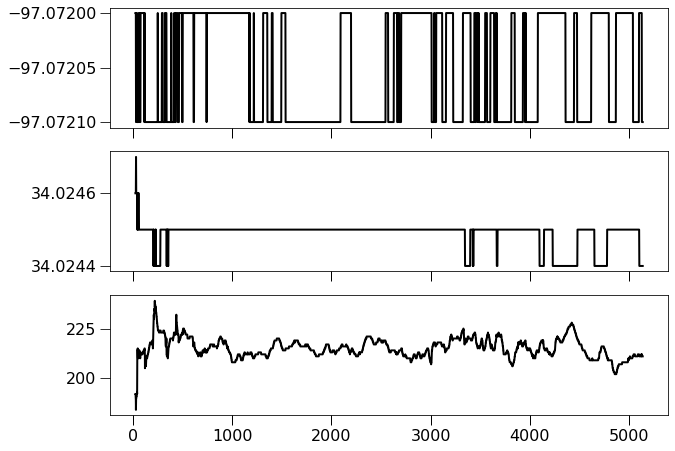

In [22]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, sharex=True)
ax1.plot(filt_gps['longitude'], color='k')
# ax1.set_ylim(-96, -98)
ax2.plot(filt_gps['latitude'], color='k')
# ax2.set_ylim(33, 35)
ax3.plot(filt_gps['altitude'], color='k')
# ax3.set_ylim(0, 30000)
ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)
ax3.ticklabel_format(useOffset=False)

# Signal processing

In [23]:
from scipy.signal import filtfilt, resample, firwin, freqz

In [24]:
def spectra_plots(df, plot_vars, freqs, bandpass_freqs=None, bandpass_response=None,
                 fig_width = 12, panel_height = 4, sample_xlim=None):
    n_vars = len(plot_vars)

    fig, axes = plt.subplots(n_vars, 1, figsize=(fig_width,panel_height*n_vars), sharex=True)
    for i, raw_var in enumerate(plot_vars):
        ax_amp = axes[i]
        ax_amp.set_ylabel(raw_var)

        h = getattr(df, raw_var)
        h = h - h.mean()

        h_f = np.fft.fft(h)
        h_amp = np.abs(h_f)/N # normalize amplitude
        # h_ph = np.angle(h_f)
        max_amp = np.max(h_amp)

        line, = ax_amp.plot(np.fft.fftshift(freqs), np.fft.fftshift(h_amp), '-k')
        if (bandpass_response is not None) & (bandpass_freqs is not None):
            bandline, = ax_amp.plot(bandpass_freqs, max_amp*np.abs(bandpass_response), '-r'), 
        ax_amp.set_xlim(0, fn)
    txt = axes[-1].set_xlabel('Frequency (Hz)')
    fig_spectra = fig
        
    fig, axes = plt.subplots(figsize=(fig_width,panel_height*n_vars), nrows=n_vars, sharex=True)
    for fname, ax in zip(plot_vars, axes):
        ax.plot(df[fname], color='k')
        ax.set_ylabel(fname)
    if sample_xlim is not None:
        axes[-1].set_xlim(sample_xlim)
    txt = axes[-1].set_xlabel('Sample')
    return fig_spectra, fig

In [25]:
sample_range = estimate_idxrange #good_accel
N = sample_range[1] - sample_range[0]

# Make sure we have an odd number of samples
if N % 2 == 0:
    # Even
    sample_range = (sample_range[0], sample_range[1]-1)

df_flight = df_fiber[slice(*sample_range)]
print(df_flight.shape)

(19999, 18)


In [26]:
t = df_flight.adc_ready_millis*1.0e-3 # seconds
delta_ts = t.diff()
dt = delta_ts.median()
fs = 1.0/dt
print("Sample frequency = {0:4.2f} Hz".format(1.0/dt))
fn = fs/2.0 # Nyquist

freqs = np.fft.fftfreq(t.shape[0], dt)

N = df_flight.shape[0]

Sample frequency = 20.00 Hz


Reference waves (accel, mag) need to have unit amplitude to not influence the final quantiative magnitude.

In [27]:
# Name and 
spin_fit_interval = 4.0
rotate_fit_interval = 8.0
default_amplitudes_intervals = {'acceleration_x':(10.0, spin_fit_interval),
                                'acceleration_y':(10.0, spin_fit_interval), 
                                'acceleration_z':(10.0, spin_fit_interval),
                                'magnetometer_x':(50.0, spin_fit_interval), 
                                'magnetometer_y':(50.0, spin_fit_interval), 
                                'magnetometer_z':(10.0, rotate_fit_interval),
                                }

new_cols = {}
for raw_var, (guess_amp, fit_interval) in default_amplitudes_intervals.items():
    print("Fitting", raw_var)
    raw_var_median = medfilt(df_flight[raw_var])
    centered = raw_var_median - raw_var_median.mean()
    fit = efmlib.cosfit(centered, fit_interval, fs, guess_amplitude=guess_amp, unit_amplitude=True)
    overlap_idx_count = fit['overlap_idx']
    new_cols['norm_'+raw_var] = fit['fitdata']
    new_cols['amp_'+raw_var] = fit['amplitude']
    new_cols['ph_'+raw_var] = fit['phase']
    new_cols['frq_'+raw_var] = fit['frequency']
    
# Check for spikes outside of range
# The median filter will get rid of "noise," esp. signle spikes, but 
# can also change the original signal a bit. Look for where big spikes were found.
medfilt_adc_volts = medfilt(df_flight['adc_volts'], 3)
medfilt_frac = np.abs(medfilt_adc_volts - df_flight['adc_volts'])/np.abs(medfilt_adc_volts)
big_spikes = (medfilt_frac > 1.5)
adc_nospike = df_flight['adc_volts'].values.copy()
adc_nospike[big_spikes] = medfilt_adc_volts[big_spikes]
new_cols['norm_adc_volts'] = adc_nospike - adc_nospike.mean()

# The above works better than trying to find values that are "too big"
# bad_adc_volts = (new_cols['norm_adc_volts'] > 5) | (new_cols['norm_adc_volts'] < -5)
# spike_fixed_adc_volts = new_cols['norm_adc_volts'].values.copy()
# spike_fixed_adc_volts[bad_adc_volts] = 0.0
# new_cols['norm_adc_volts'] = spike_fixed_adc_volts

df_flight = df_flight.assign(**new_cols)

Fitting acceleration_x
Actual interval to match sampling rate is 4.00 s for given 4.0 s
Fitting acceleration_y
Actual interval to match sampling rate is 4.00 s for given 4.0 s
Fitting acceleration_z
Actual interval to match sampling rate is 4.00 s for given 4.0 s
Fitting magnetometer_x
Actual interval to match sampling rate is 4.00 s for given 4.0 s
Fitting magnetometer_y
Actual interval to match sampling rate is 4.00 s for given 4.0 s
Fitting magnetometer_z
Actual interval to match sampling rate is 8.00 s for given 8.0 s


In [28]:
# test_fit = efmlib.cosfit(df_flight['acceleration_x'], 4.0, fs, guess_amplitude=10.0, unit_amplitude=True)
# overlap_idx_count = test_fit.pop('overlap_idx')

# test_fit_vars = list(test_fit.keys())
# fig, axes = plt.subplots(len(test_fit_vars), figsize=(12,12), sharex=True)
# subset = slice(None, None)
# for var, ax in zip(test_fit_vars, axes):
#     ax.set_ylabel(var)
#     ax.plot(test_fit[var][subset], '-k')

## Prefiltering

Find spin frequency from peak of ar, at and then apply a bandpass filter to the spin-coupled signals. The passband needs to include the secondary lobes due to the rotation frequency.

The plots below diagnose the fitted cosine amplitude, phase, and frequency for each of the reference sinusoids. Amplitudes should be fairly steady, phase of spin-coupled signals should cycle in a steady ramp, with x and y offset by pi/2, and the magnetometer z phase shouldn't jump around too much.

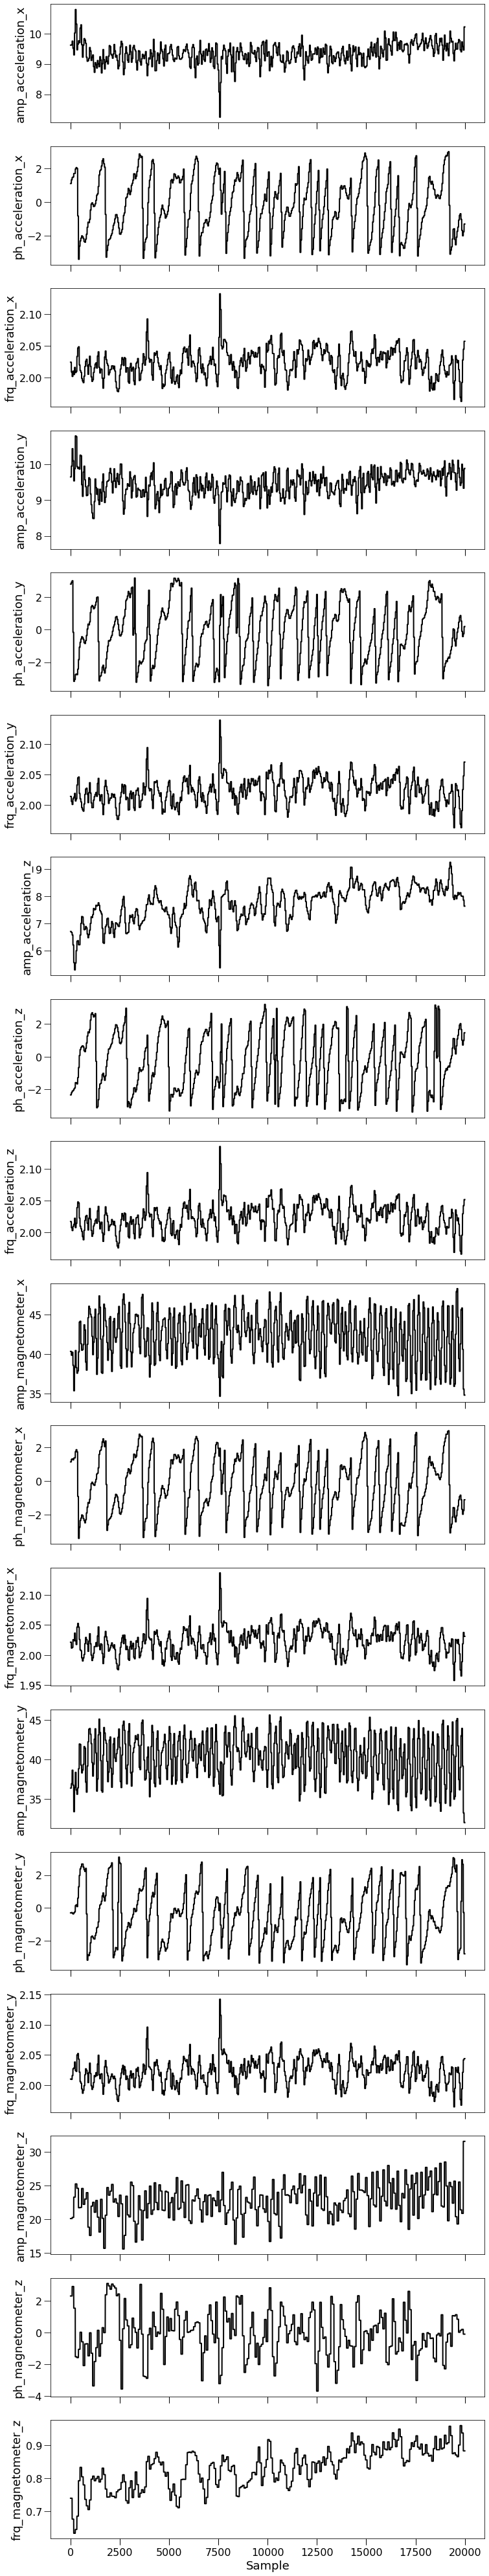

In [29]:
fitted_vars = ['norm_acceleration_x', 'norm_acceleration_y', 'norm_acceleration_z',
               'norm_magnetometer_x', 'norm_magnetometer_y', 'norm_magnetometer_z',]

fit_cos_amplitude_vars = [s.replace('norm', 'amp') for s in fitted_vars]
fit_cos_phase_vars = [s.replace('norm', 'ph') for s in fitted_vars]
fit_cos_freq_vars = [s.replace('norm', 'frq') for s in fitted_vars]

n_panels = len(fitted_vars)*3
fig, axes = plt.subplots(n_panels, sharex=True, figsize=(12,4*n_panels))

for ivar, (var0, var1, var2) in enumerate(list(zip(fit_cos_amplitude_vars, fit_cos_phase_vars, fit_cos_freq_vars))):
    axes[ivar*3+0].plot(df_flight[var0], color='k')
    axes[ivar*3+1].plot(df_flight[var1], color='k')
    axes[ivar*3+2].plot(df_flight[var2], color='k')
    axes[ivar*3+0].set_ylabel(var0)
    axes[ivar*3+1].set_ylabel(var1)
    axes[ivar*3+2].set_ylabel(var2)
#     axes[-1].set_xlim(sample_xlim)
    txt = axes[-1].set_xlabel('Sample')
fig.savefig('fitted_sensor_amp_ph_frq.pdf')

In [30]:
fft_ar_raw = np.fft.fft(df_flight['norm_acceleration_x'])
fft_at_raw = np.fft.fft(df_flight['norm_acceleration_y'])

if N % 2 == 0:
    # Even
    N_mid = int(N/2)
else:
    N_mid = int((N-1)/2)

skip_dc = 10
# Get the max frequency from the pos freq half of the FFT
spin_freq_ar = freqs[skip_dc:N_mid][np.argmax(np.abs(fft_ar_raw[skip_dc:N_mid]))]
spin_freq_at = freqs[skip_dc:N_mid][np.argmax(np.abs(fft_at_raw[skip_dc:N_mid]))]

print("Spin frequency from ar, at is {0:3.2f}, {1:3.2f} Hz".format(spin_freq_ar, spin_freq_at))

Spin frequency from ar, at is 2.01, 2.01 Hz


In [31]:
# halfbw = spin_freq_ar / 2.0 
halfbw = 0.12*fn
passband_ar = [spin_freq_ar-halfbw, spin_freq_ar+halfbw];
bp_filter_order = 40
bandpass_coeff = firwin(bp_filter_order, passband_ar, fs=fs, pass_zero='bandpass')
bandpass_freqs, bandpass_response = freqz(bandpass_coeff, 1, fs=fs)


In [32]:
# orig_spectra_plots = ['acceleration_x', 'acceleration_y', 'acceleration_z',
#                     'magnetometer_x', 'magnetometer_y', 'magnetometer_z',
#                     'adc_volts',]

# figs = spectra_plots(df_flight, orig_spectra_plots, freqs,
#               bandpass_freqs=bandpass_freqs, bandpass_response=bandpass_response)

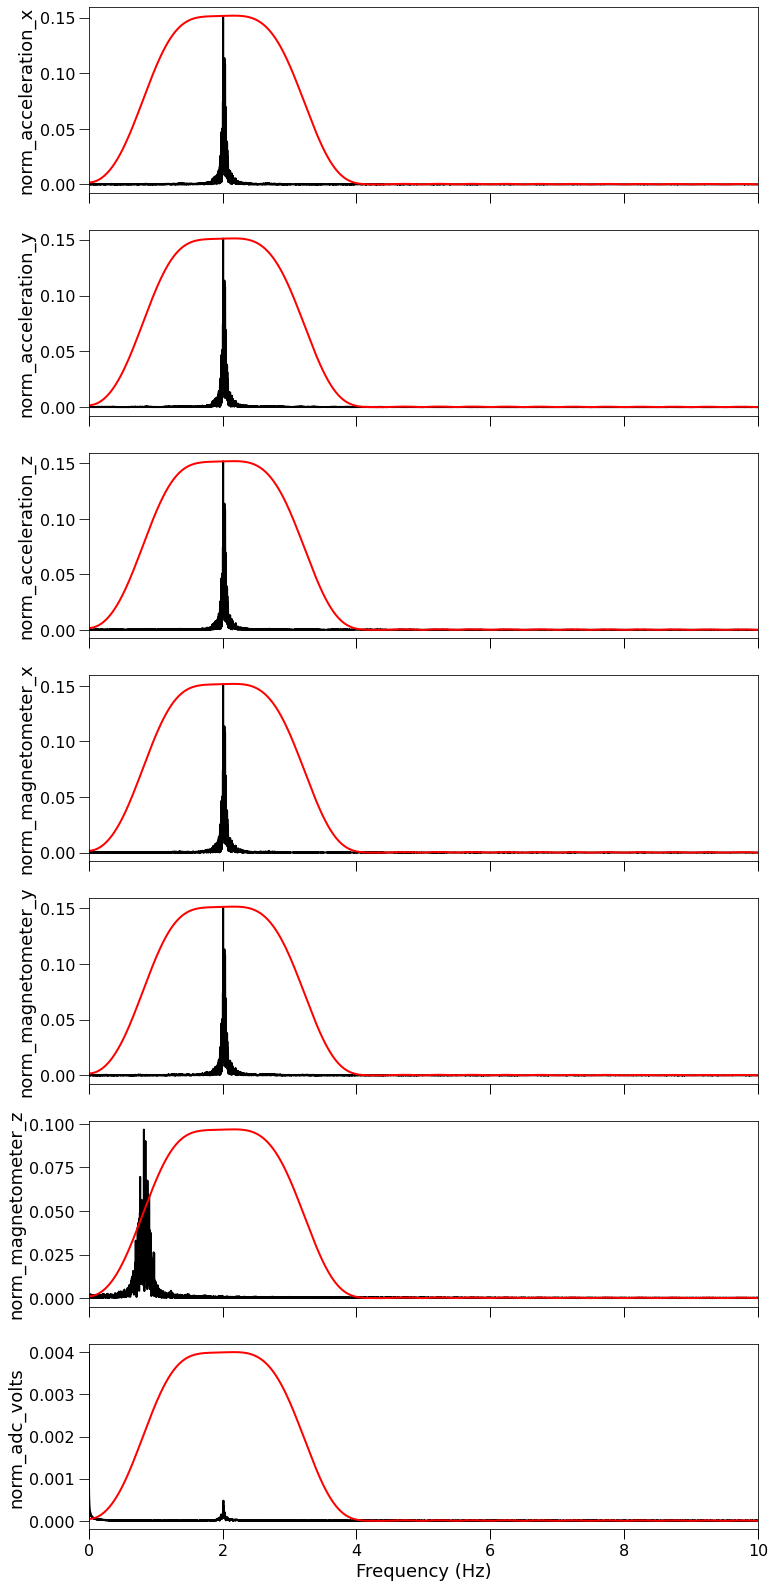

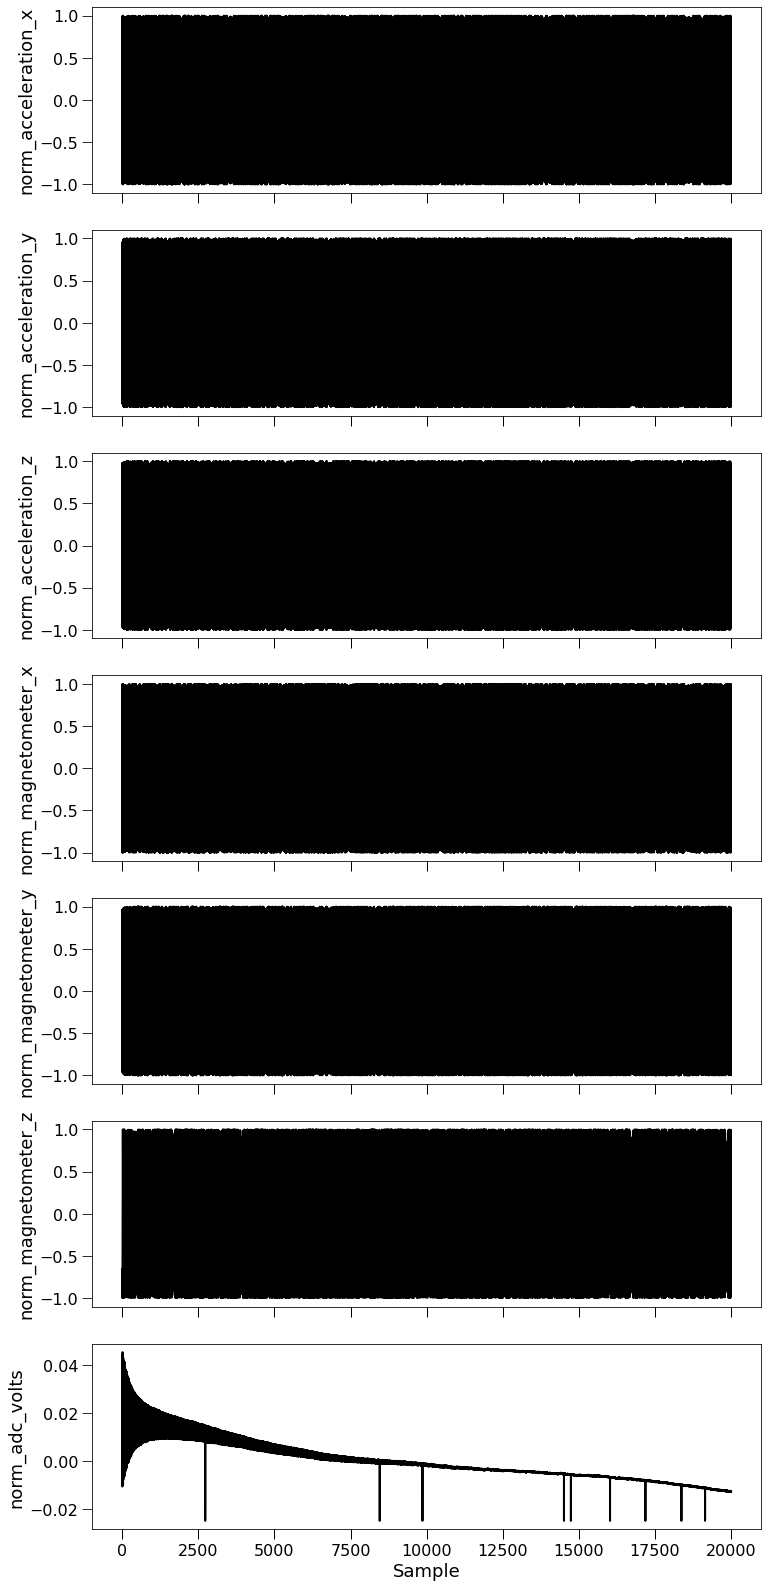

In [33]:
raw_spectra_plots = ['norm_acceleration_x', 'norm_acceleration_y', 'norm_acceleration_z',
                    'norm_magnetometer_x', 'norm_magnetometer_y', 'norm_magnetometer_z',
                    'norm_adc_volts',]

figs = spectra_plots(df_flight, raw_spectra_plots, freqs,
              bandpass_freqs=bandpass_freqs, bandpass_response=bandpass_response)

Filter the spin-coupled signals.

In [34]:
bp_to_assign = dict(
    ar_bp_no_norm = filtfilt(bandpass_coeff,1,df_flight['acceleration_x']),
    at_bp_no_norm = filtfilt(bandpass_coeff,1,df_flight['acceleration_y']),
    ar_bp = filtfilt(bandpass_coeff,1,df_flight['norm_acceleration_x']),
    at_bp = filtfilt(bandpass_coeff,1,df_flight['norm_acceleration_y']),
    br_bp = filtfilt(bandpass_coeff,1,df_flight['norm_magnetometer_x']),
    bt_bp = filtfilt(bandpass_coeff,1,df_flight['norm_magnetometer_y']),
    E_bp_with_lag  = filtfilt(bandpass_coeff,1,df_flight['norm_adc_volts']),
    )
df_flight = df_flight.assign(**bp_to_assign)

In [35]:
from efmlib import fix_adc_offset
df_flight = df_flight.assign(E_bp = fix_adc_offset(df_flight, adc_var='E_bp_with_lag',dt=0.0875))

Shifting ADC backward by 1.8 original samples.


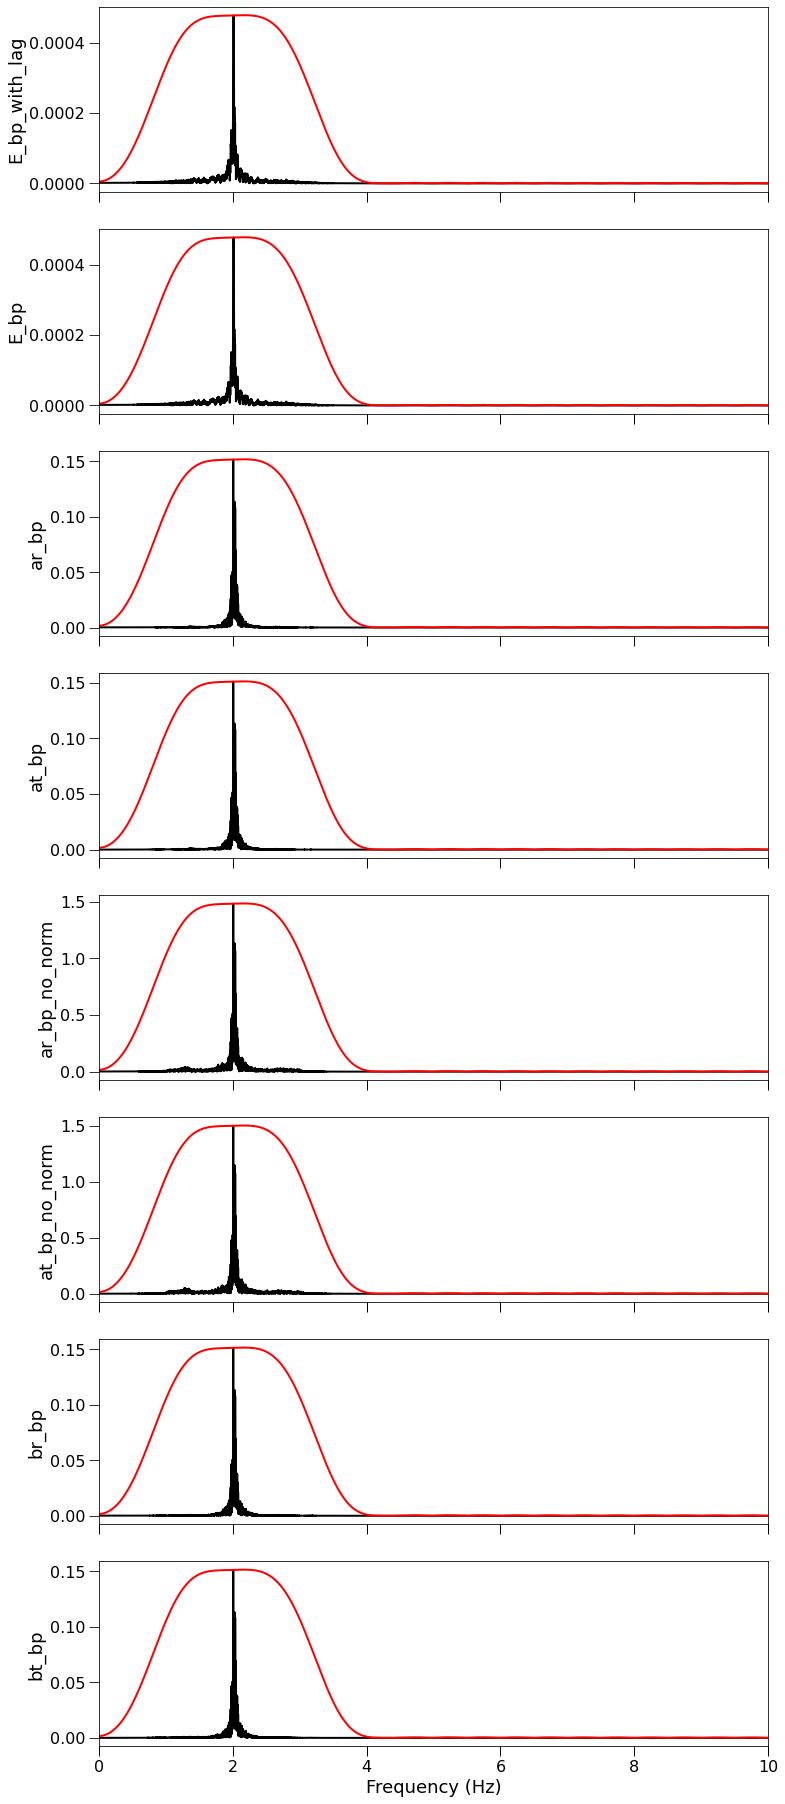

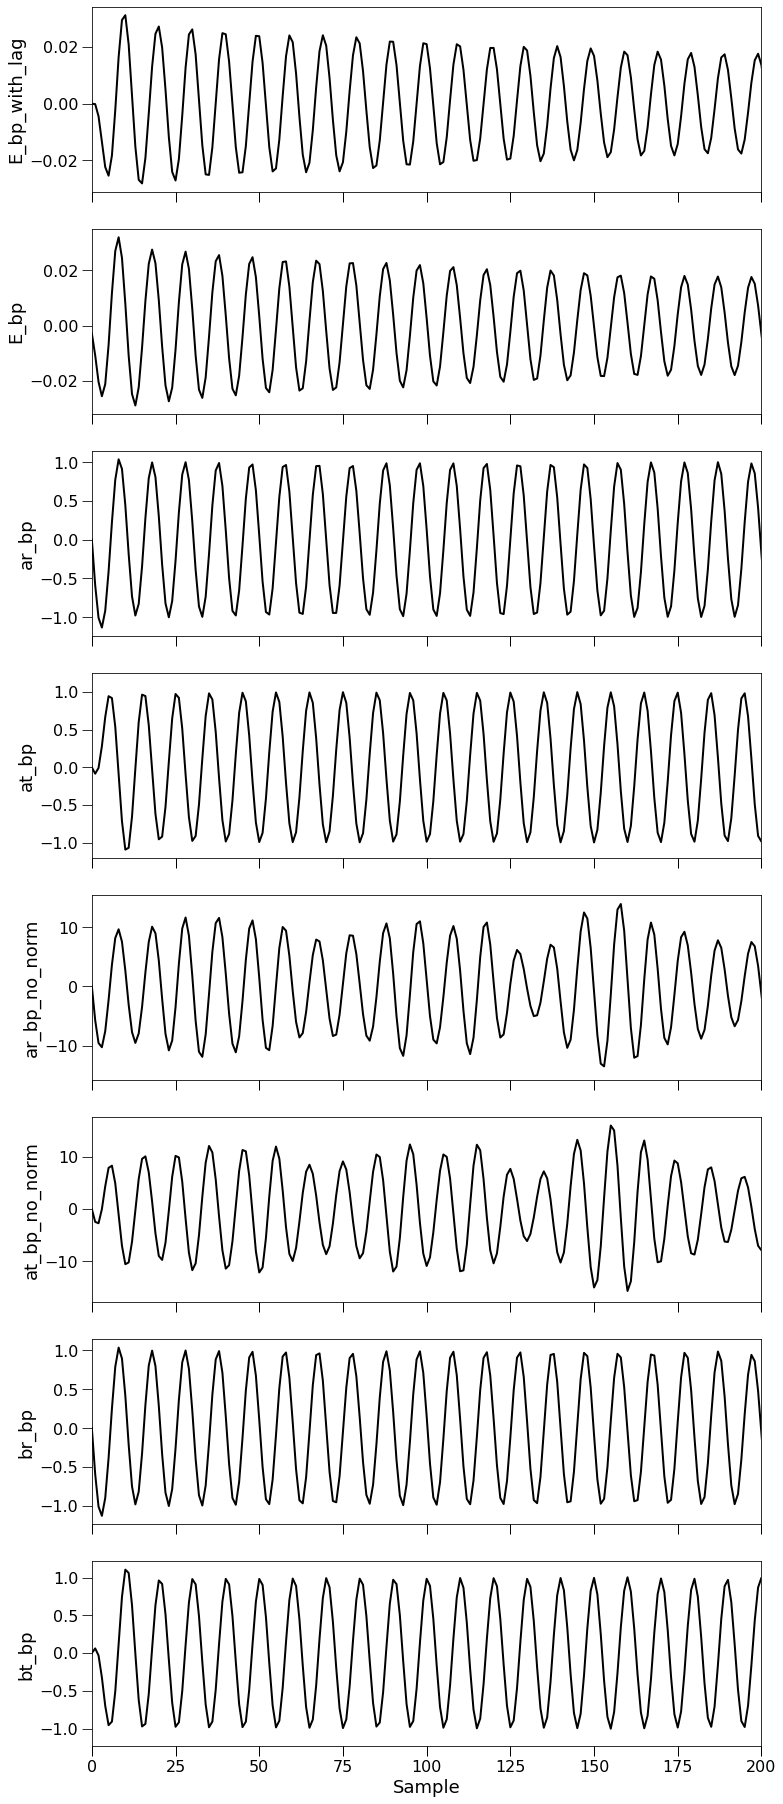

In [36]:
bp_spectra_plots = ['E_bp_with_lag', 'E_bp', 'ar_bp', 'at_bp', 'ar_bp_no_norm', 'at_bp_no_norm', 'br_bp', 'bt_bp']

figs = spectra_plots(df_flight, bp_spectra_plots, freqs, sample_xlim=(0,200),
              bandpass_freqs=bandpass_freqs, bandpass_response=bandpass_response)

## Upsampling

In [37]:
# TODO: which of ax, ay, az coorespond to radial, tangential, axial?
upsample_factor = 4
up_len = df_flight.shape[0]*upsample_factor
fs_up = fs*upsample_factor
f_nyquist_up = fn*upsample_factor
freqs_up = np.fft.fftfreq(up_len, dt/upsample_factor)

df_up = pd.DataFrame.from_dict(dict(
    t_up = resample(df_flight.adc_ready_millis*1.0e-3, up_len),
    ar_bp_no_norm_up = resample(df_flight['ar_bp_no_norm'], up_len),
    at_bp_no_norm_up = resample(df_flight['at_bp_no_norm'], up_len),
    ar_bp_up = resample(df_flight['ar_bp'], up_len),
    at_bp_up = resample(df_flight['at_bp'], up_len),
    aa_up = resample(df_flight['norm_acceleration_z'], up_len),
    Br_bp_up = resample(df_flight['br_bp'], up_len),
    Bt_bp_up = resample(df_flight['bt_bp'], up_len),
    Ba_up = resample(df_flight['norm_magnetometer_z'], up_len),
    E_bp_up = resample(df_flight['E_bp'], up_len),
    ))

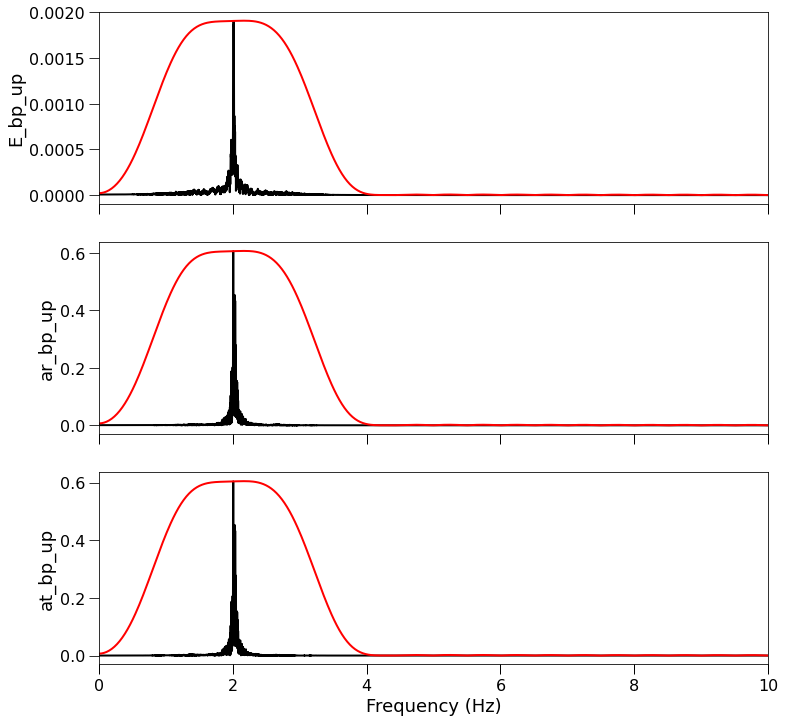

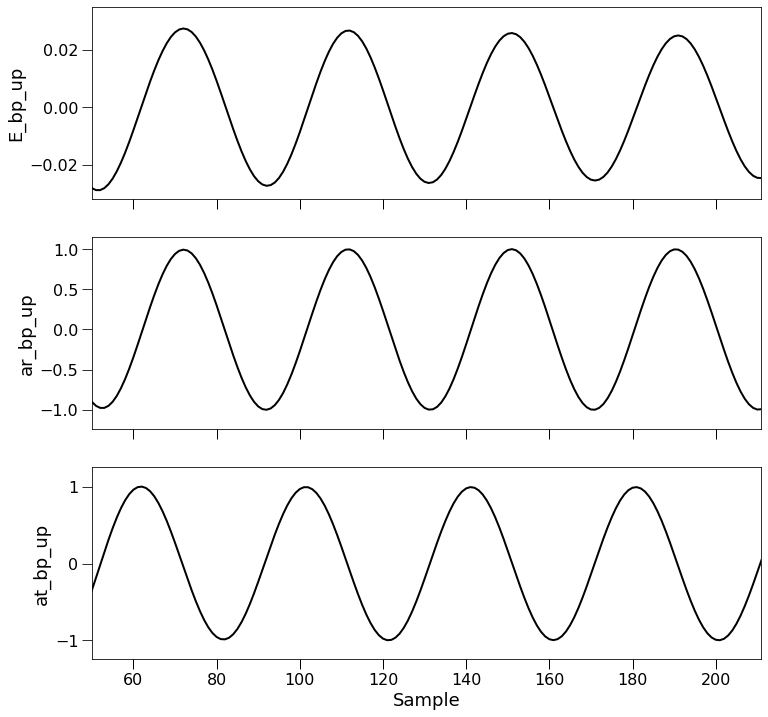

In [38]:
bp_spectra_plots_up = ['E_bp_up', 'ar_bp_up', 'at_bp_up']

figs = spectra_plots(df_up, bp_spectra_plots_up, freqs_up, sample_xlim=(50,50*upsample_factor+11),
              bandpass_freqs=bandpass_freqs, bandpass_response=bandpass_response)

## Demodulate the vertical component

In [39]:
# Demodulating (E) with a sine wave (ar or at) gives an average value
#    x=1/2 * A. So, need to multiply by two after demod.
Ev_up_data = dict(
    Ev_in_up = 2 * df_up.E_bp_up * df_up.ar_bp_up,
    Ev_quad_up = 2 * df_up.E_bp_up * df_up.at_bp_up,
    )
df_up = df_up.assign(**Ev_up_data)

Now lowpass filter the signals to get the demodulated data values.

NOTE: The filter needs to be FLAT out to highest precession frequency!! (Otherwise the amplitude of E_h will vary with precession frequency!)

This makes E_v (and E_h) noisy, but can refilter both signals later after
demodulating out E_h, with narrower bandwidth to reduce noise and give
good transient response. (N2 = 200 and Wn2 = 1/60 will be best for this.)

(Final filter order should be ~4*order of BP of non-interpolated data.)

In [40]:
halfbw_lp = f_nyquist_up / 20 #spin_freq_ar
lp_filter_order = 4*bp_filter_order
lowpass_coeff = firwin(lp_filter_order, halfbw_lp, fs=fs_up,
                       pass_zero='lowpass', window='blackman')
lowpass_freqs, lowpass_response = freqz(lowpass_coeff, 1, fs=fs_up)


(<Figure size 864x576 with 2 Axes>, <Figure size 864x576 with 2 Axes>)

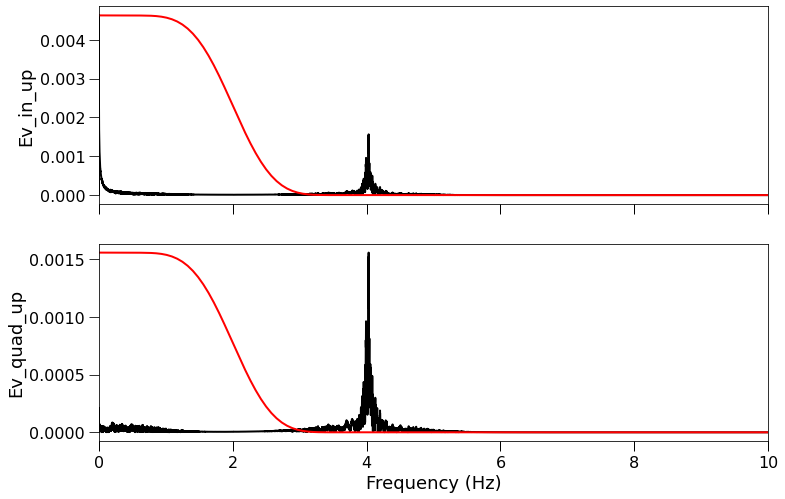

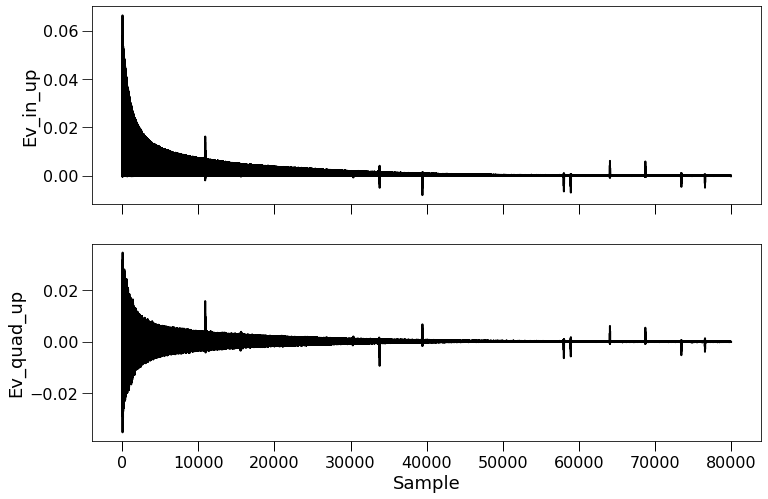

In [41]:
spectra_plots(df_up, ['Ev_in_up', 'Ev_quad_up'], freqs_up,
              bandpass_freqs=lowpass_freqs, bandpass_response=lowpass_response)

In [42]:
up_to_assign = dict(
    Ev_up = filtfilt(lowpass_coeff,1,df_up.Ev_in_up), # Vertical E
    Eh_up = filtfilt(lowpass_coeff,1,df_up.Ev_quad_up), # Horizontal E
)
df_up = df_up.assign(**up_to_assign)

(<Figure size 864x576 with 2 Axes>, <Figure size 864x576 with 2 Axes>)

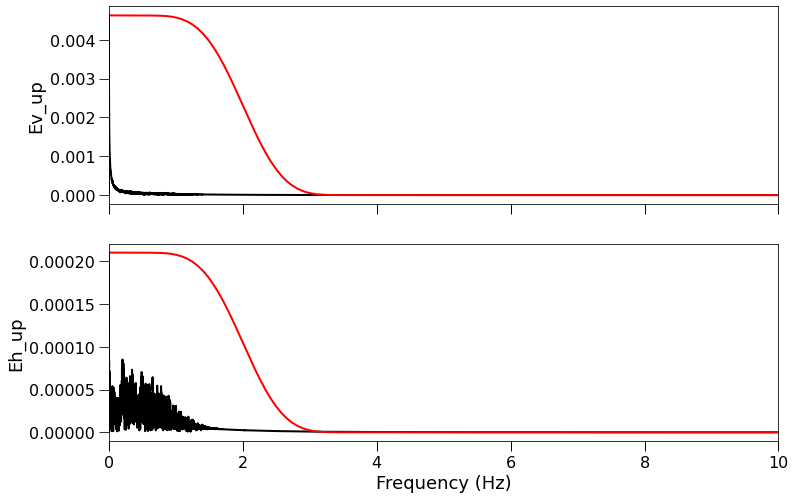

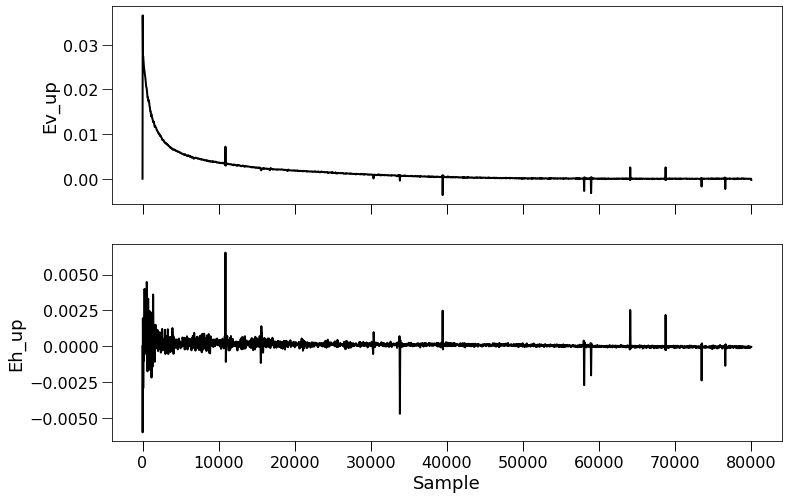

In [43]:
spectra_plots(df_up, ['Ev_up', 'Eh_up'], freqs_up, 
              bandpass_freqs=lowpass_freqs, bandpass_response=lowpass_response)

## Demodulate the accelerometer to get pendulum

This kind of works to find the envelope.

Leftover signal is g*cos(phi), so divide by g to get cos(phi) and take arccos to get phi.

In [44]:
# Demodulating (E) with a sine wave (ar or at) gives an average value
#    x=1/2 * A. So, need to multiply by two after demod.
g_up_data = dict(
    g_ar_up = 2 * df_up.ar_bp_no_norm_up * df_up.ar_bp_up,
    g_at_up = 2 * df_up.at_bp_no_norm_up * df_up.at_bp_up,
    )
df_up = df_up.assign(**g_up_data)

In [45]:
up_to_assign = dict(
    gravity_ar = filtfilt(lowpass_coeff,1,df_up.g_ar_up), # Vertical E
    gravity_at = filtfilt(lowpass_coeff,1,df_up.g_at_up), # Horizontal E
)
up_to_assign['gravity'] = (up_to_assign['gravity_ar'] - up_to_assign['gravity_at'])/2.0
mean_gravity = up_to_assign['gravity'].mean()
pend_angle = np.arccos((up_to_assign['gravity']/mean_gravity))
up_to_assign['pendulum_angle'] = np.degrees(pend_angle)
df_up = df_up.assign(**up_to_assign)

print(mean_gravity)

-0.06236258671276043


/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arccos
  import sys


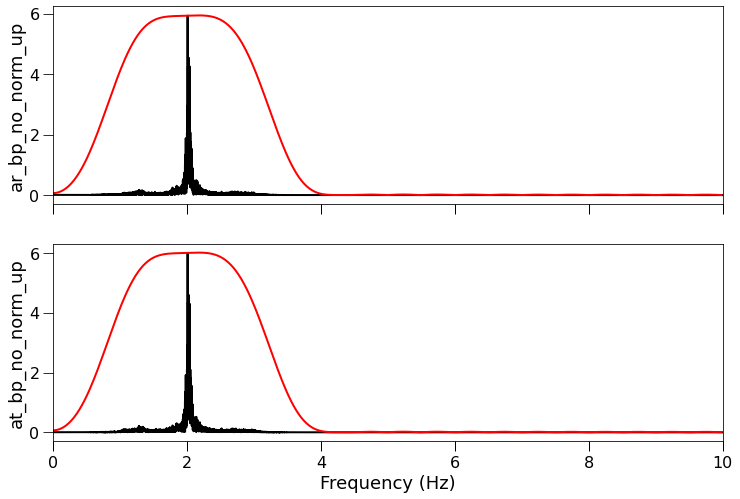

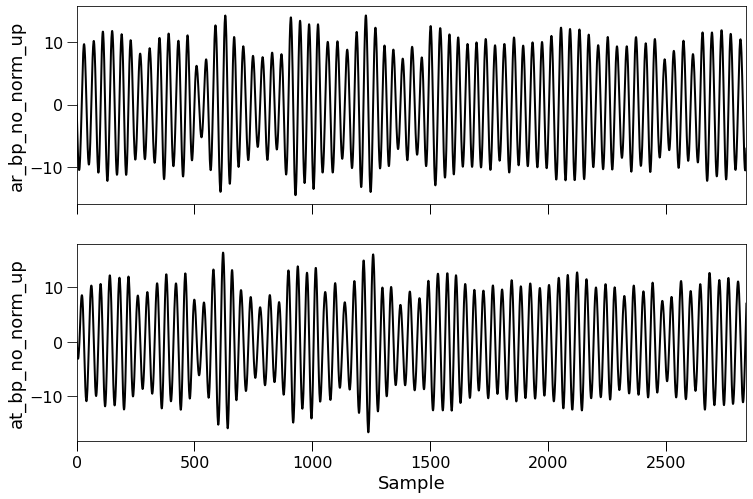

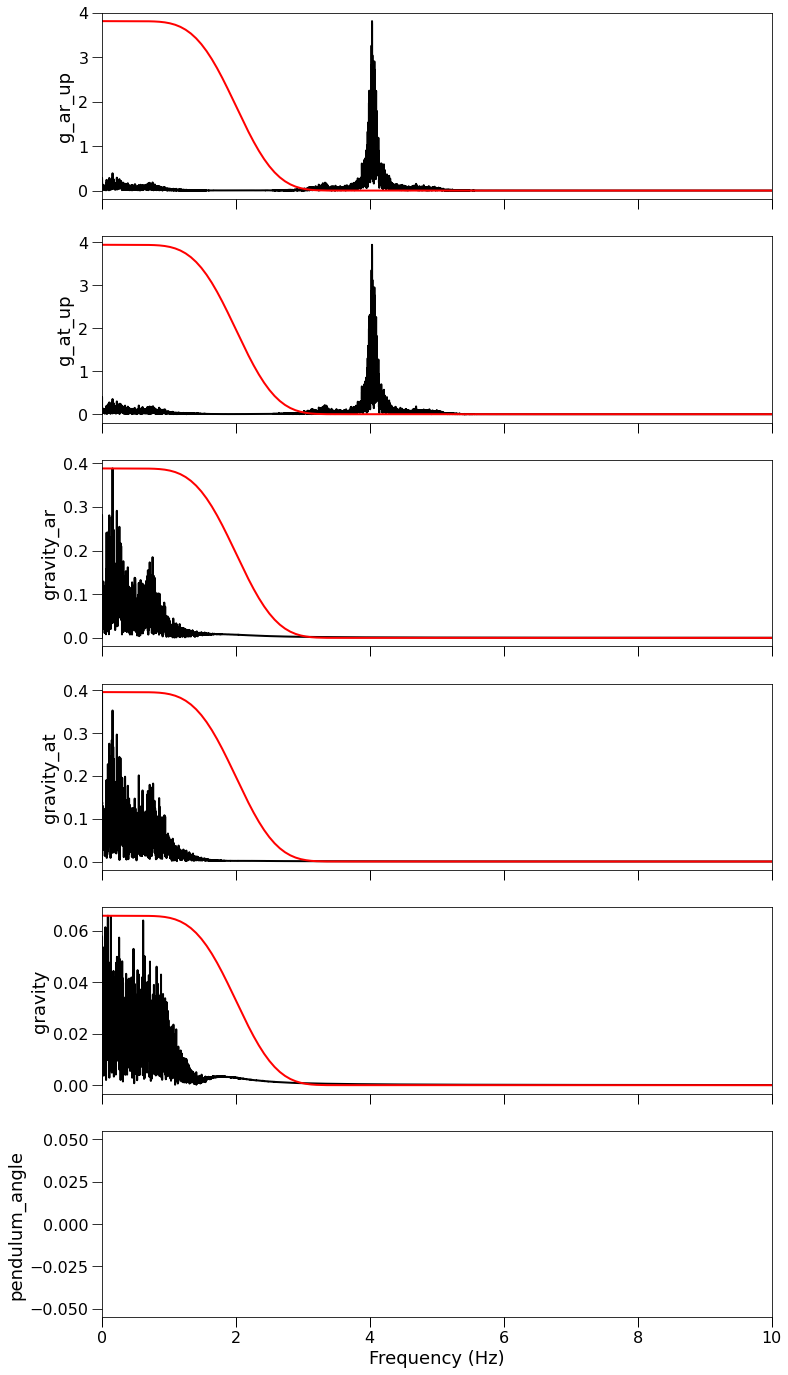

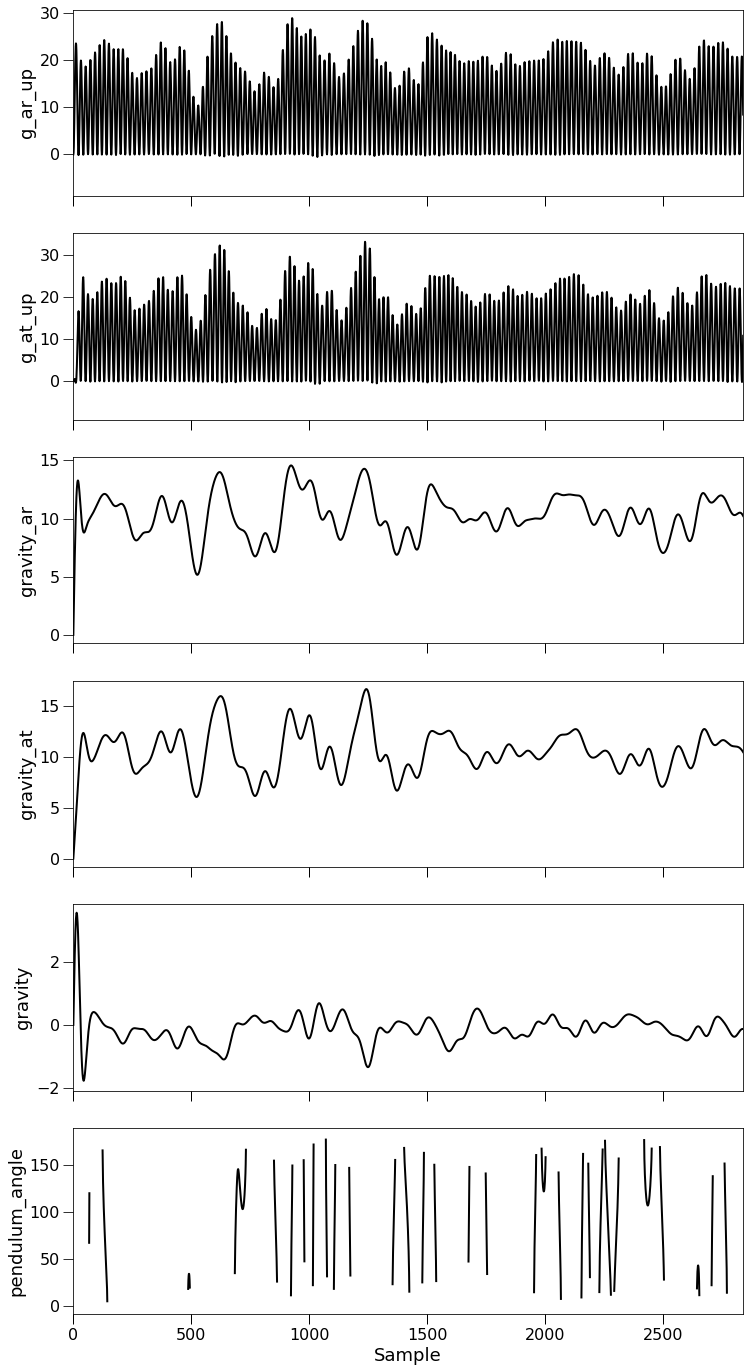

In [46]:
spectra_plots(df_up, ['ar_bp_no_norm_up', 'at_bp_no_norm_up'], freqs_up, sample_xlim=(0,710*upsample_factor),
              bandpass_freqs=bandpass_freqs, bandpass_response=bandpass_response)
spectra_plots(df_up, ['g_ar_up', 'g_at_up', 'gravity_ar', 'gravity_at', 'gravity', 'pendulum_angle'], freqs_up, sample_xlim=(0,710*upsample_factor),
              bandpass_freqs=lowpass_freqs, bandpass_response=lowpass_response)
plt.savefig('gravity_retrieval_test.pdf')

## Demodulate the horizontal components

We have the along-axis reference signal for B directly (df_up.Ba_up). The component orthogonal to it can be calculated from the axial and tangential components of the accelerometer and magnetometer, followed by a low pass filter.

The tuning of this filter has a big impact on the transient response. In other words, how many points it will take to represent an instant delta-E from lightning.

In [47]:
# The sign here is different from the previous processing (sum, not differnce), suggesting that we 
# have switched the spin (or maybe rotation) direction?
# Need to work through theory to make sense of this.
Bh_up_raw = (df_up.Br_bp_up * df_up.at_bp_up) + (df_up.Bt_bp_up * df_up.ar_bp_up)

bh_amp_guess, bh_fit_interval = default_amplitudes_intervals['magnetometer_z']
Bh_up_fit = efmlib.cosfit(Bh_up_raw, bh_fit_interval, fs_up, guess_amplitude=bh_amp_guess, unit_amplitude=True)
Bh_up = Bh_up_fit['fitdata']
df_up = df_up.assign(
    Bh_up = Bh_up,
    Eh_in_up = 2 * df_up.Eh_up * df_up.Ba_up,
    Eh_quad_up = 2 * df_up.Eh_up * Bh_up,
)

Actual interval to match sampling rate is 8.00 s for given 8.0 s


In [48]:
# halfbw_Eh_lp = f_nyquist_up/240
halfbw_Eh_lp = f_nyquist_up/16
print(halfbw_Eh_lp)
lp_Eh_filter_order = 400 #4*bp_filter_order
lowpass_Eh_coeff = firwin(lp_Eh_filter_order, halfbw_Eh_lp, fs=fs_up,
                       pass_zero='lowpass', window='blackman')
lowpass_Eh_freqs, lowpass_Eh_response = freqz(lowpass_Eh_coeff, 1, fs=fs_up)


2.5000000000022737


(<Figure size 864x1152 with 4 Axes>, <Figure size 864x1152 with 4 Axes>)

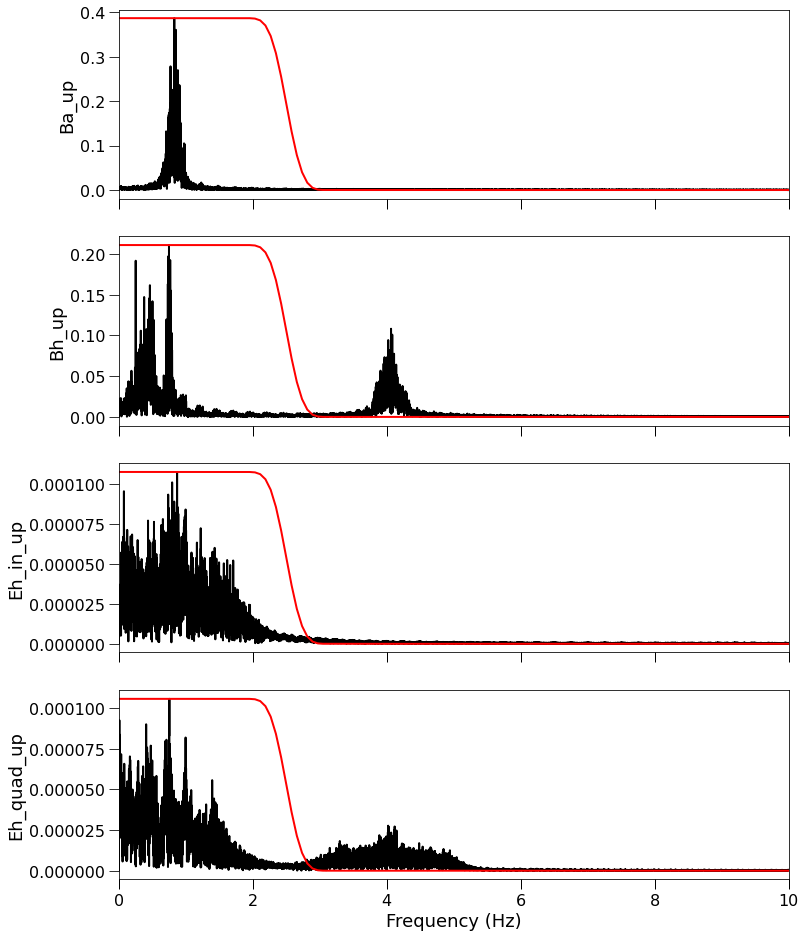

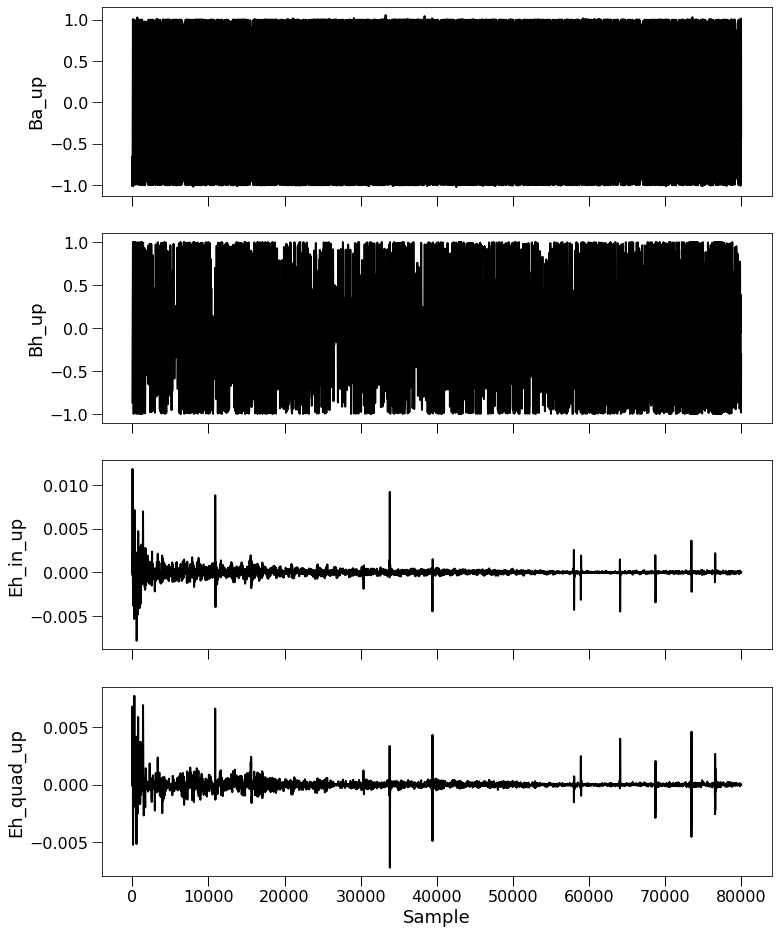

In [49]:
spectra_plots(df_up, ['Ba_up', 'Bh_up','Eh_in_up', 'Eh_quad_up',], freqs_up, #sample_xlim=(0,2500),
              bandpass_freqs=lowpass_Eh_freqs, bandpass_response=lowpass_Eh_response)

(<Figure size 864x864 with 3 Axes>, <Figure size 864x864 with 3 Axes>)

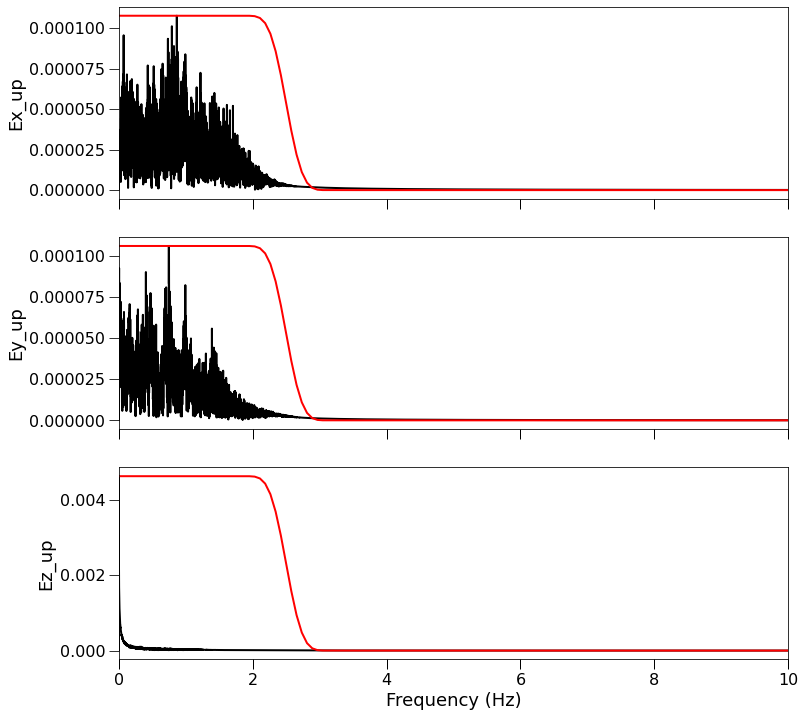

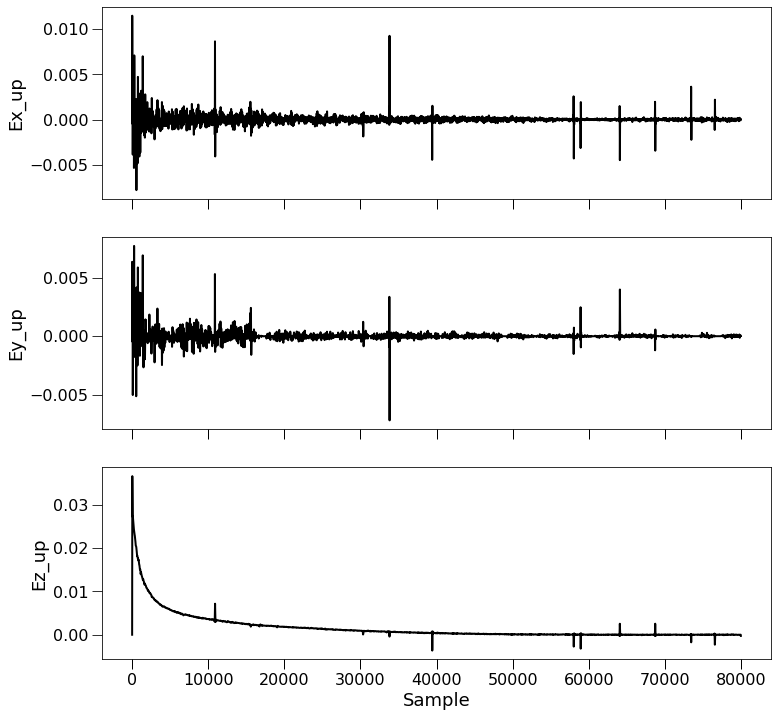

In [50]:
df_up = df_up.assign(
    Ex_up = filtfilt(lowpass_Eh_coeff,1,df_up.Eh_in_up),
    Ey_up = filtfilt(lowpass_Eh_coeff,1,df_up.Eh_quad_up),
    Ez_up = filtfilt(lowpass_Eh_coeff,1,df_up.Ev_up),
)

spectra_plots(df_up, ['Ex_up', 'Ey_up','Ez_up',], freqs_up, #sample_xlim=(0,1500),
              bandpass_freqs=lowpass_Eh_freqs, bandpass_response=lowpass_Eh_response)

In [51]:
Ex = calibrated_E(df_up.Ex_up)
Ey = calibrated_E(df_up.Ey_up)
Ez = -calibrated_E(df_up.Ez_up)

for v in (
        Ex[0:1000].mean(),
        Ey[0:1000].mean(),
        Ez[0:1000].mean()
        ):
    print(v)
    


-8.54919676939055
33.09065487514095
-930.3217964377803


In [52]:
def gish44(z):
    "Calculate the fair weather electric field from Gish (1944, MacGorman and Rust eq. 1.11) from altitude in km"
    E = 81.8*np.exp(-4.52*z) + 38.6*np.exp(-.375*z) + 10.27*np.exp(-.121*z)
    return -E

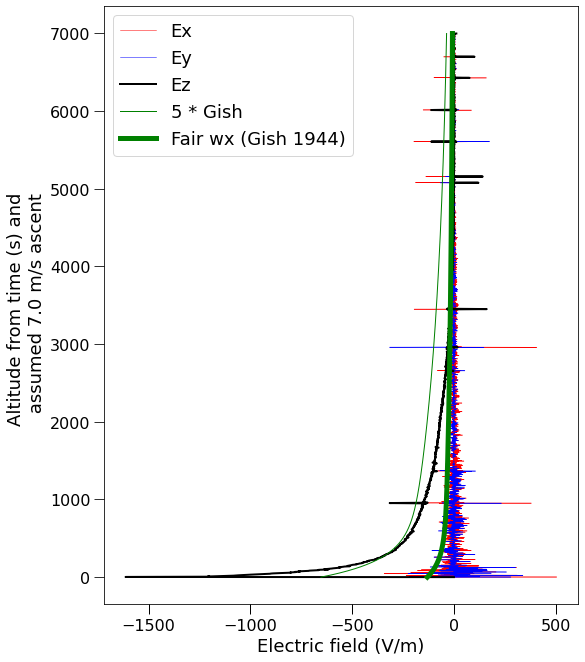

In [53]:
fig, ax=plt.subplots(1,1,figsize=(8.5, 11))
# Altitude, eventually
ax.set_xlabel('Electric field (V/m)')


ascent = 7.0
y_coord = np.arange(Ex.shape[0])/fs_up*ascent
# ax.set_ylabel('Sample (upsampled x4)')
ax.set_ylabel('Altitude from time (s) and \n assumed {0} m/s ascent'.format(ascent))

# y_coord = df_up.t_up

gish_mult = 5

ax.plot(Ex, y_coord, '-r', linewidth=0.5, label='Ex')
ax.plot(Ey, y_coord, '-b', linewidth=0.5, label='Ey')
ax.plot(Ez, y_coord, '-k', linewidth=2.0, label='Ez')

# ax.plot(calibrated_E(peak_peak_range))
ax.plot(gish_mult*gish44(y_coord/1000.0), y_coord, '-g', linewidth=1.0, label=f'{gish_mult} * Gish')
ax.plot(gish44(y_coord/1000.0), y_coord, '-g', linewidth=5.0, label=f'Fair wx (Gish 1944)')


ax.legend()
# ax.set_ylim(0,500)
fig.savefig('Exyz.pdf')

In [54]:
rho = 8.854e-12 * np.gradient(Ez, (1.0/fs_up)*ascent)
print(rho)

[-1.24133012e-08 -1.23705704e-08 -1.22429741e-08 ...  9.36651652e-11
  9.46612147e-11  9.49948719e-11]


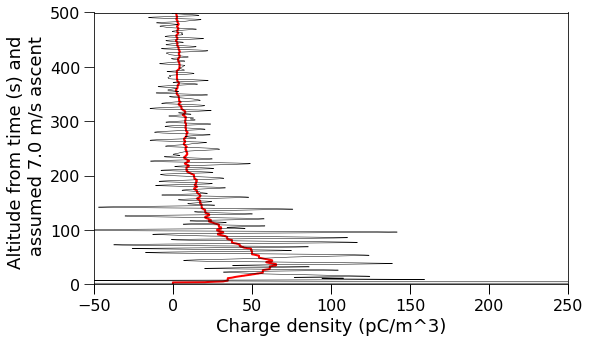

In [55]:
fig, ax=plt.subplots(1,1,figsize=(8.5, 5))
# Altitude, eventually
ax.set_xlabel('Charge density (pC/m^3)')
ax.set_ylabel('Altitude from time (s) and \n assumed {0} m/s ascent'.format(ascent))
ax.plot(medfilt(rho*1e12,801), y_coord, '-r', linewidth=2.0)
ax.plot(rho*1e12, y_coord, '-k', linewidth=0.5)
ax.set_xlim(-.05e3,.25e3)
ax.set_ylim(0, 500)
fig.savefig('rho.pdf')

(0.0, 2000.0)

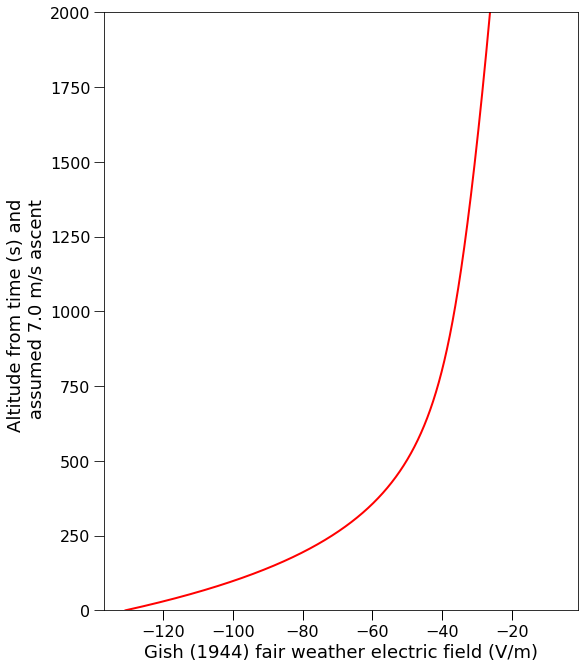

In [56]:
fig, ax=plt.subplots(1,1,figsize=(8.5, 11))
# Altitude, eventually
ax.set_xlabel('Gish (1944) fair weather electric field (V/m)')
ax.set_ylabel('Altitude from time (s) and \n assumed {0} m/s ascent'.format(ascent))
ax.plot(gish44(y_coord/1000.0), y_coord, '-r', linewidth=2.0)
# ax.set_xlim(-.25e3,.05e3)
ax.set_ylim(0, 2000)